## **This notebook aims to combine multiple assets databases**

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [3]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [4]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

In [5]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

#### **Last data modifications**

In [6]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

## **Sequential evaluation function**

In [28]:

def repackage_hidden(h):
    """
    Evita que el grafo de cómputo se mantenga de un batch al siguiente
    (detach de los tensores).
    """
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def entrenar_modelo(model, 
                    trainloader, 
                    valloader, 
                    criterion, 
                    optimizer, 
                    num_epochs, 
                    device):
    
    """
    Entrena y valida un modelo secuencial (por ejemplo, LSTM) asegurando
    que se mantenga la secuencialidad de los datos y la propagación del
    estado oculto, si aplica.
    """

    model.to(device)
    
    # Listas para guardar las curvas de pérdida
    epoch_train_losses = []
    epoch_val_losses = []

    # Bucle principal de epochs
    for epoch in range(num_epochs):
        model.train()  # Modo entrenamiento

        # --- (1) ENTRENAMIENTO --- 
        # Si tu modelo LSTM/GRU necesita un estado inicial, lo inicializas aquí:
        # Por ejemplo, si model tiene un método init_hidden(batch_size):
        # hidden = model.init_hidden(trainloader.batch_size)
        # De lo contrario, pon hidden=None o maneja la lógica necesaria.
        
        hidden = None
        total_train_loss = 0.0

        for X_batch, y_batch in trainloader:
            # Movemos los datos al dispositivo
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Detach del estado oculto (si tu modelo maneja hidden states)
            if hidden is not None:
                hidden = repackage_hidden(hidden)

            # Reseteamos gradientes
            optimizer.zero_grad()

            # Forward
            # Si tu modelo retorna (output, hidden), por ejemplo en una LSTM:
            if hidden is not None:
                pred_y, hidden = model(X_batch, hidden)
            else:
                # Si es la primera vez o tu modelo no requiere hidden externo
                pred_y = model(X_batch)

            loss = criterion(pred_y, y_batch)

            # Backprop
            loss.backward()

            # (Opcional) Clip de gradientes para evitar exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Actualizar parámetros
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        # --- (2) VALIDACIÓN ---
        if valloader is not None:
            model.eval()
            total_val_loss = 0.0
            
            hidden_val = None
            with torch.no_grad():
                for X_val, y_val in valloader:
                    X_val, y_val = X_val.to(device), y_val.to(device)

                    if hidden_val is not None:
                        hidden_val = repackage_hidden(hidden_val)

                    pred_val = model(X_val)
                    loss_val = criterion(pred_val, y_val)
                    total_val_loss += loss_val.item()

            avg_val_loss = total_val_loss / len(valloader)
            epoch_val_losses.append(avg_val_loss)
        else:
            epoch_val_losses.append(None)

        # --- (3) LOGGING: Mostrar progreso ---
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_val_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f} | "
                      f"Val Loss: {avg_val_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    return epoch_train_losses, epoch_val_losses


### **Evaluation function**

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    epoch_train_losses, epoch_val_losses = entrenar_modelo(model, 
                    trainloader, 
                    valloader, 
                    criterion, 
                    optimizer, 
                    num_epochs, 
                    device)
    
    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        
        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] ",
                      f"Train Loss: {avg_train_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


In [30]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_sequential(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    epoch_train_losses, epoch_val_losses = entrenar_modelo(model, trainloader, valloader, criterion, optimizer, num_epochs, device)
    
    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses
    }


## **Run LSTM and GRU Models**

In [8]:
possible_train_size = 95

num_epochs = 100
prediction_threshold = 0.5

learning_rate = 0.01

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

----- SECURITY TYPE: single_name, WINDOW SIZE: 5, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6924 | Val Loss: 0.6894
[Epoch 10/100] Train Loss: 0.6893 | Val Loss: 0.6986
[Epoch 15/100] Train Loss: 0.6859 | Val Loss: 0.7105
[Epoch 20/100] Train Loss: 0.6815 | Val Loss: 0.7187
[Epoch 25/100] Train Loss: 0.6764 | Val Loss: 0.7241
[Epoch 30/100] Train Loss: 0.6716 | Val Loss: 0.7239
[Epoch 35/100] Train Loss: 0.6672 | Val Loss: 0.7238
[Epoch 40/100] Train Loss: 0.6611 | Val Loss: 0.7236
[Epoch 45/100] Train Loss: 0.6563 | Val Loss: 0.7219
[Epoch 50/100] Train Loss: 0.6519 | Val Loss: 0.7189
[Epoch 55/100] Train Loss: 0.6476 | Val Loss: 0.7162
[Epoch 60/100] Train Loss: 0.6430 | Val Loss: 0.7137
[Epoch 65/100] Train Loss: 0.6378 | Val Loss: 0.7134
[Epoch 70/100] Train Loss: 0.6327 | Val Loss: 0.7104
[Epoch 75/100] Train Loss: 0.6272 | Val Loss: 0.7058
[Epoch 80/100] Train Loss: 0.6218 | Val Loss: 0.7011
[Epoch 

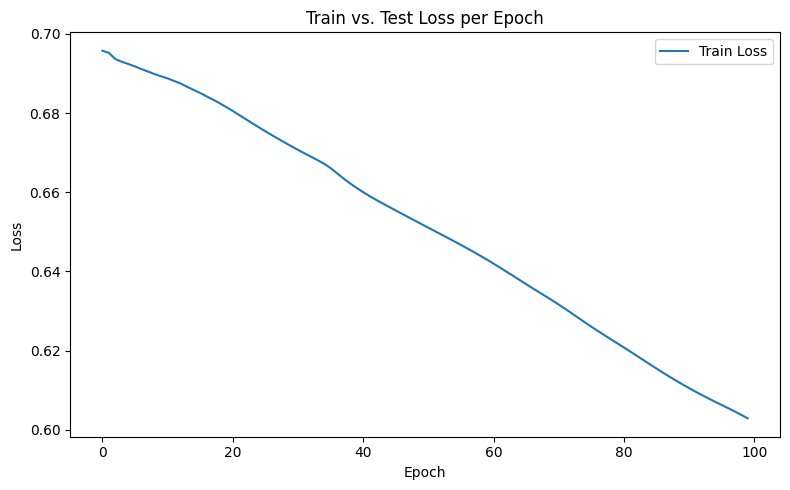

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6927 | Val Loss: 0.6880
[Epoch 10/100] Train Loss: 0.6894 | Val Loss: 0.6969
[Epoch 15/100] Train Loss: 0.6858 | Val Loss: 0.7048
[Epoch 20/100] Train Loss: 0.6821 | Val Loss: 0.7060
[Epoch 25/100] Train Loss: 0.6784 | Val Loss: 0.7137
[Epoch 30/100] Train Loss: 0.6740 | Val Loss: 0.7263
[Epoch 35/100] Train Loss: 0.6688 | Val Loss: 0.7381
[Epoch 40/100] Train Loss: 0.6633 | Val Loss: 0.7438
[Epoch 45/100] Train Loss: 0.6573 | Val Loss: 0.7423
[Epoch 50/100] Train Loss: 0.6511 | Val Loss: 0.7413
[Epoch 55/100] Train Loss: 0.6446 | Val Loss: 0.7465
[Epoch 60/100] Train Loss: 0.6384 | Val Loss: 0.7519
[Epoch 65/100] Train Loss: 0.6328 | Val Loss: 0.7540
[Epoch 70/100] Train Loss: 0.6276 | Val Loss: 0.7564
[Epoch 75/100] Train Loss: 0.6226 | Val Loss: 0.7610
[Epoch 80/100] Train 

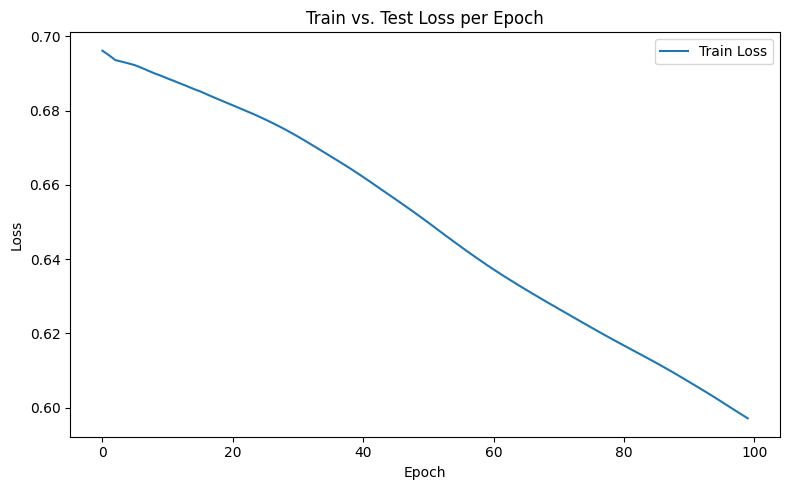

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6926 | Val Loss: 0.6881
[Epoch 10/100] Train Loss: 0.6892 | Val Loss: 0.7003
[Epoch 15/100] Train Loss: 0.6854 | Val Loss: 0.7139
[Epoch 20/100] Train Loss: 0.6816 | Val Loss: 0.7130
[Epoch 25/100] Train Loss: 0.6775 | Val Loss: 0.7073
[Epoch 30/100] Train Loss: 0.6729 | Val Loss: 0.7030
[Epoch 35/100] Train Loss: 0.6679 | Val Loss: 0.7030
[Epoch 40/100] Train Loss: 0.6635 | Val Loss: 0.7047
[Epoch 45/100] Train Loss: 0.6588 | Val Loss: 0.7034
[Epoch 50/100] Train Loss: 0.6529 | Val Loss: 0.6991
[Epoch 55/100] Train Loss: 0.6458 | Val Loss: 0.6981
[Epoch 60/100] Train Loss: 0.6393 | Val Loss: 0.6958
[Epoch 65/100] Train Loss: 0.6334 | Val Loss: 0.6946
[Epoch 70/100] Train Loss: 0.6277 | Val Loss: 0.6975
[Epoch 75/100] Train Loss: 0.6229 | Val Loss: 0.7005
[Epoch 80/100] Train 

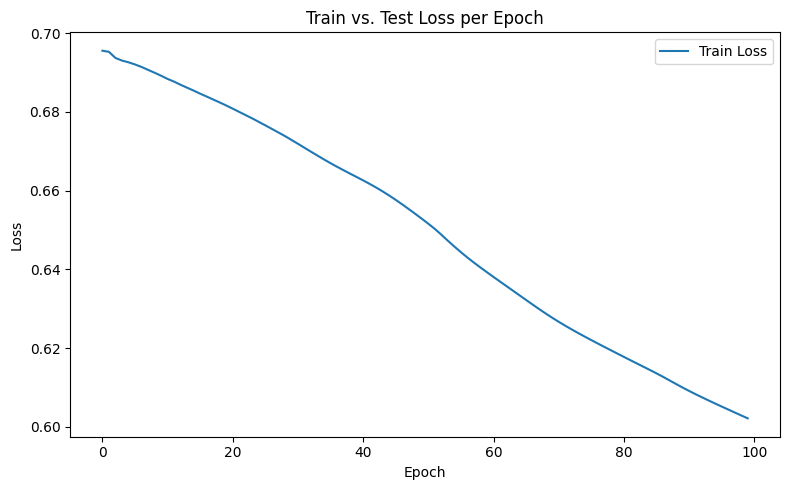

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6928 | Val Loss: 0.6852
[Epoch 10/100] Train Loss: 0.6896 | Val Loss: 0.6989
[Epoch 15/100] Train Loss: 0.6867 | Val Loss: 0.7105
[Epoch 20/100] Train Loss: 0.6828 | Val Loss: 0.7152
[Epoch 25/100] Train Loss: 0.6770 | Val Loss: 0.7141
[Epoch 30/100] Train Loss: 0.6711 | Val Loss: 0.7027
[Epoch 35/100] Train Loss: 0.6657 | Val Loss: 0.6929
[Epoch 40/100] Train Loss: 0.6613 | Val Loss: 0.6885
[Epoch 45/100] Train Loss: 0.6575 | Val Loss: 0.6864
[Epoch 50/100] Train Loss: 0.6543 | Val Loss: 0.6836
[Epoch 55/100] Train Loss: 0.6514 | Val Loss: 0.6796
[Epoch 60/100] Train Loss: 0.6487 | Val Loss: 0.6736
[Epoch 65/100] Train Loss: 0.6448 | Val Loss: 0.6651
[Epoch 70/100] Train Loss: 0.6405 | Val Loss: 0.6540
[Epoch 75/100] Train Loss: 0.6369 | Val Loss: 0.6467
[Epoch 80/100] Train 

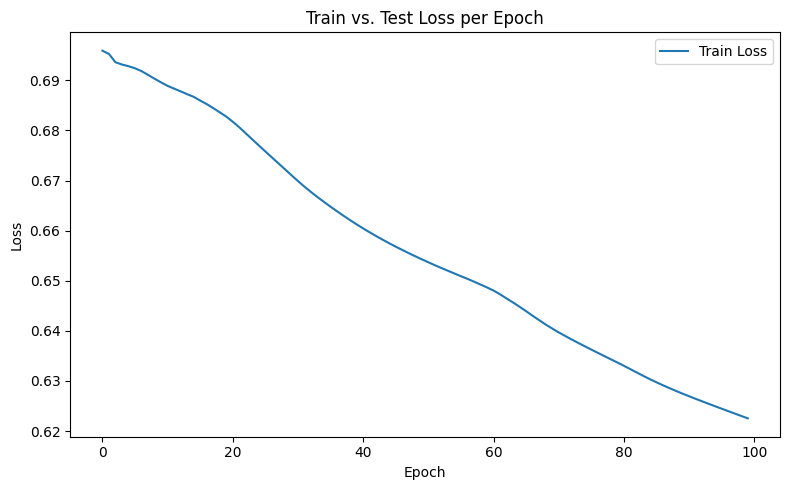

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6925 | Val Loss: 0.6897
[Epoch 10/100] Train Loss: 0.6888 | Val Loss: 0.7004
[Epoch 15/100] Train Loss: 0.6852 | Val Loss: 0.7131
[Epoch 20/100] Train Loss: 0.6822 | Val Loss: 0.7195
[Epoch 25/100] Train Loss: 0.6791 | Val Loss: 0.7230
[Epoch 30/100] Train Loss: 0.6752 | Val Loss: 0.7243
[Epoch 35/100] Train Loss: 0.6712 | Val Loss: 0.7261
[Epoch 40/100] Train Loss: 0.6673 | Val Loss: 0.7285
[Epoch 45/100] Train Loss: 0.6624 | Val Loss: 0.7308
[Epoch 50/100] Train Loss: 0.6575 | Val Loss: 0.7328
[Epoch 55/100] Train Loss: 0.6523 | Val Loss: 0.7348
[Epoch 60/100] Train Loss: 0.6468 | Val Loss: 0.7357
[Epoch 65/100] Train Loss: 0.6411 | Val Loss: 0.7350
[Epoch 70/100] Train Loss: 0.6346 | Val Loss: 0.7350
[Epoch 75/100] Train Loss: 0.6270 | Val Loss: 0.7403
[Epoch 80/100] Train 

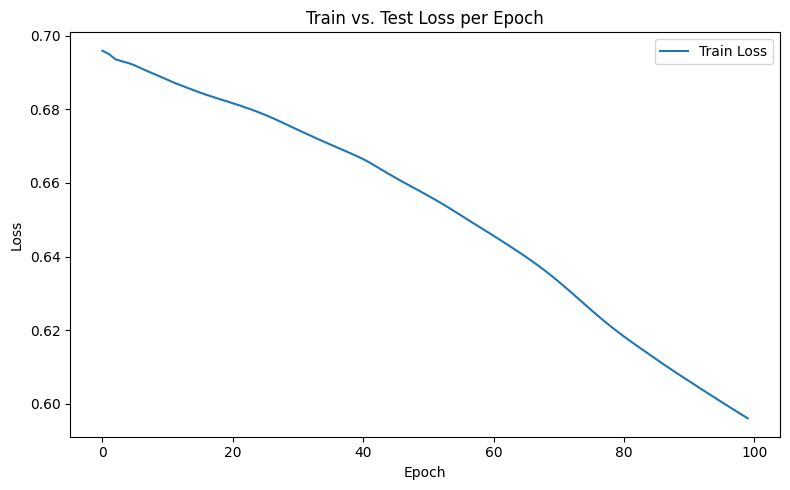

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6944 | Val Loss: 0.6933
[Epoch 10/100] Train Loss: 0.6925 | Val Loss: 0.6943
[Epoch 15/100] Train Loss: 0.6905 | Val Loss: 0.6937
[Epoch 20/100] Train Loss: 0.6862 | Val Loss: 0.7008
[Epoch 25/100] Train Loss: 0.6826 | Val Loss: 0.6952
[Epoch 30/100] Train Loss: 0.6724 | Val Loss: 0.7099
[Epoch 35/100] Train Loss: 0.6688 | Val Loss: 0.6970
[Epoch 40/100] Train Loss: 0.6573 | Val Loss: 0.7170
[Epoch 45/100] Train Loss: 0.6497 | Val Loss: 0.7592
[Epoch 50/100] Train Loss: 0.6348 | Val Loss: 0.7688
[Epoch 55/100] Train Loss: 0.6302 | Val Loss: 0.7635
[Epoch 60/100] Train Loss: 0.6179 | Val Loss: 0.8166
[Epoch 65/100] Train Loss: 0.6147 | Val Loss: 0.7942
[Epoch 70/100] Train Loss: 0.6065 | Val Loss: 0.8147
[Epoch 75/100] Train Loss: 0.5936 | Val Loss: 0.7926
[Epoch 80/100] Train 

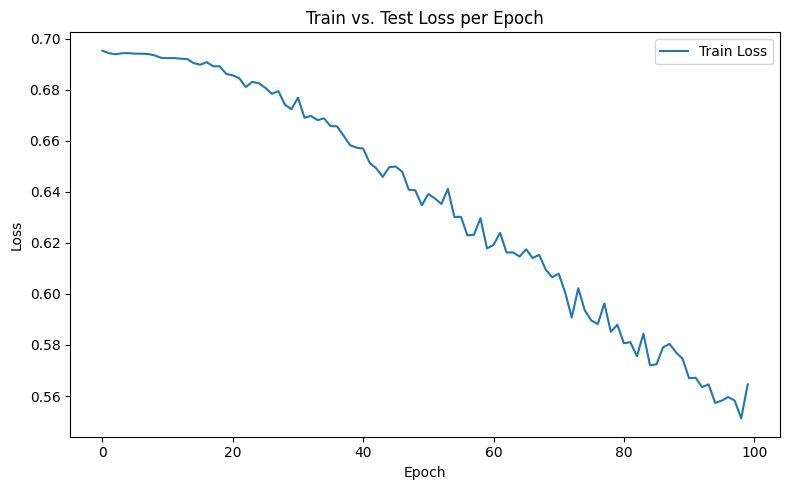

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6944 | Val Loss: 0.6929
[Epoch 10/100] Train Loss: 0.6927 | Val Loss: 0.6927
[Epoch 15/100] Train Loss: 0.6892 | Val Loss: 0.6925
[Epoch 20/100] Train Loss: 0.6857 | Val Loss: 0.6785
[Epoch 25/100] Train Loss: 0.6794 | Val Loss: 0.6654
[Epoch 30/100] Train Loss: 0.6774 | Val Loss: 0.7028
[Epoch 35/100] Train Loss: 0.6679 | Val Loss: 0.6933
[Epoch 40/100] Train Loss: 0.6589 | Val Loss: 0.7260
[Epoch 45/100] Train Loss: 0.6483 | Val Loss: 0.6921
[Epoch 50/100] Train Loss: 0.6427 | Val Loss: 0.7154
[Epoch 55/100] Train Loss: 0.6367 | Val Loss: 0.6550
[Epoch 60/100] Train Loss: 0.6273 | Val Loss: 0.7025
[Epoch 65/100] Train Loss: 0.6176 | Val Loss: 0.7198
[Epoch 70/100] Train Loss: 0.6161 | Val Loss: 0.7289
[Epoch 75/100] Train Loss: 0.5937 | Val Loss: 0.6992
[Epoch 80/100] Train 

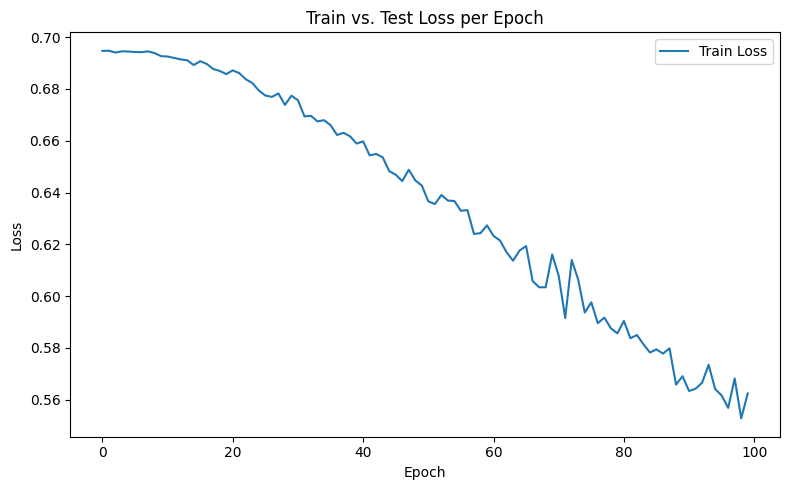

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6943 | Val Loss: 0.6923
[Epoch 10/100] Train Loss: 0.6929 | Val Loss: 0.6915
[Epoch 15/100] Train Loss: 0.6926 | Val Loss: 0.6863
[Epoch 20/100] Train Loss: 0.6886 | Val Loss: 0.6819
[Epoch 25/100] Train Loss: 0.6832 | Val Loss: 0.6710
[Epoch 30/100] Train Loss: 0.6786 | Val Loss: 0.6819
[Epoch 35/100] Train Loss: 0.6720 | Val Loss: 0.6812
[Epoch 40/100] Train Loss: 0.6635 | Val Loss: 0.6988
[Epoch 45/100] Train Loss: 0.6587 | Val Loss: 0.7039
[Epoch 50/100] Train Loss: 0.6450 | Val Loss: 0.6884
[Epoch 55/100] Train Loss: 0.6403 | Val Loss: 0.7084
[Epoch 60/100] Train Loss: 0.6300 | Val Loss: 0.6864
[Epoch 65/100] Train Loss: 0.6292 | Val Loss: 0.7540
[Epoch 70/100] Train Loss: 0.6067 | Val Loss: 0.7268
[Epoch 75/100] Train Loss: 0.5996 | Val Loss: 0.7676
[Epoch 80/100] Train 

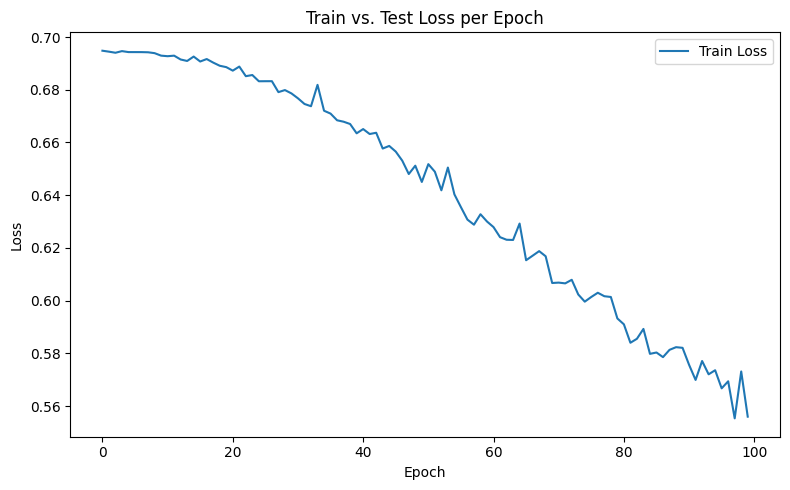

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6942 | Val Loss: 0.6939
[Epoch 10/100] Train Loss: 0.6930 | Val Loss: 0.6869
[Epoch 15/100] Train Loss: 0.6916 | Val Loss: 0.6964
[Epoch 20/100] Train Loss: 0.6912 | Val Loss: 0.6911
[Epoch 25/100] Train Loss: 0.6875 | Val Loss: 0.7036
[Epoch 30/100] Train Loss: 0.6808 | Val Loss: 0.7057
[Epoch 35/100] Train Loss: 0.6779 | Val Loss: 0.7109
[Epoch 40/100] Train Loss: 0.6710 | Val Loss: 0.7086
[Epoch 45/100] Train Loss: 0.6620 | Val Loss: 0.7101
[Epoch 50/100] Train Loss: 0.6504 | Val Loss: 0.7303
[Epoch 55/100] Train Loss: 0.6399 | Val Loss: 0.7496
[Epoch 60/100] Train Loss: 0.6275 | Val Loss: 0.7389
[Epoch 65/100] Train Loss: 0.6188 | Val Loss: 0.7402
[Epoch 70/100] Train Loss: 0.6110 | Val Loss: 0.7515
[Epoch 75/100] Train Loss: 0.5993 | Val Loss: 0.7059
[Epoch 80/100] Train 

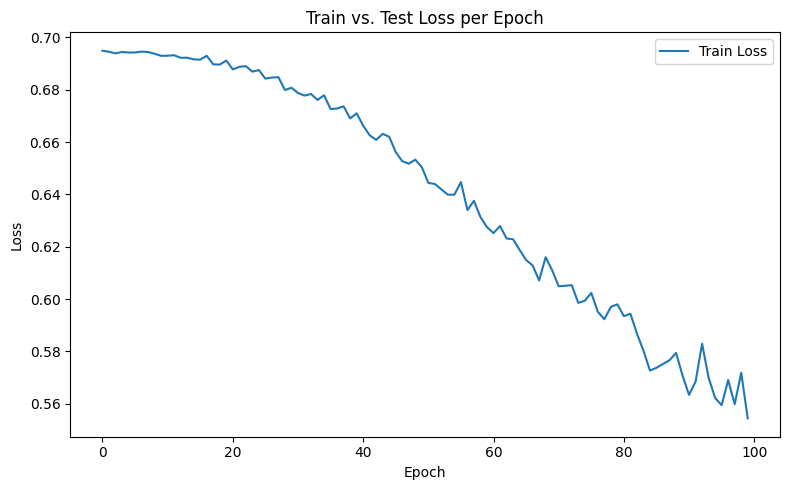

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6943 | Val Loss: 0.6935
[Epoch 10/100] Train Loss: 0.6927 | Val Loss: 0.6899
[Epoch 15/100] Train Loss: 0.6912 | Val Loss: 0.6987
[Epoch 20/100] Train Loss: 0.6884 | Val Loss: 0.6974
[Epoch 25/100] Train Loss: 0.6840 | Val Loss: 0.6976
[Epoch 30/100] Train Loss: 0.6832 | Val Loss: 0.7102
[Epoch 35/100] Train Loss: 0.6709 | Val Loss: 0.7175
[Epoch 40/100] Train Loss: 0.6666 | Val Loss: 0.6948
[Epoch 45/100] Train Loss: 0.6512 | Val Loss: 0.6898
[Epoch 50/100] Train Loss: 0.6469 | Val Loss: 0.6875
[Epoch 55/100] Train Loss: 0.6330 | Val Loss: 0.7045
[Epoch 60/100] Train Loss: 0.6228 | Val Loss: 0.6659


KeyboardInterrupt: 

In [31]:
model_types = ["lstm", "gru"]   
sample_size = 5
processing = "clean"
period = "10y"
security_types = ["single_name", "options", "technical"]
window_sizes = [5]
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
stock = stocks[-1]
results_list = []

for security_type in security_types:
    for window_size in window_sizes:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- SECURITY TYPE: {security_type}, WINDOW SIZE: {window_size}, STOCK: {stock} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        input_size = X_resampled.shape[2]
        train_size = int(X_resampled.shape[0] * possible_train_size / 100)
        # train_size = X_combined.shape[0]-30
        test_size = X_resampled.shape[0] - train_size

        for model_type in model_types:
            for i in range(sample_size):
                if model_type == "gru":
                    model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
                elif model_type == "lstm":
                    model = StockPriceLSTM(input_size, hidden_size, output_size)

                model = model.to(device)

                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                print(f"Training {stocks[-1]} | LR: {learning_rate} | Epochs: {num_epochs} "
                      f"| Batch: {batch_size} | Security type: {security_type}")


                result = evaluate_model_sequential(
                    model, 
                    X_resampled, 
                    y_resampled, 
                    criterion, 
                    optimizer, 
                    device, 
                    train_size, 
                    batch_size, 
                    num_epochs, 
                    lower_threshold = 0.5,
                    plots_dir=plots_dir,
                    plot_filename=None
                )

                # Store results in a list
                results_list.append({
                    "stock": stock,
                    "security_type": security_type,
                    "window_size": window_size,
                    "model_type": model_type,
                    "iteration": i + 1,
                    "accuracy_nonzero": result["accuracy_nonzero"],
                    "loss_decrease_percentage": result["loss_decrease_percentage"],
                    "final_train_loss": result["final_train_loss"]
                })

results_df = pd.DataFrame(results_list)

In [11]:
results_df = pd.DataFrame(results_list)
output_folder = os.path.join(results_dir, 'combined_vs_individual_v1')
results_df.to_csv(os.path.join(output_folder, f'uncombined_single_name_{stock}.csv'), index=False)

In [12]:
results_df

,stock,security_type,window_size,model_type,iteration,accuracy_nonzero,loss_decrease_percentage,final_train_loss
0,SPX,single_name,5,lstm,1,0.557252,-13.955419,0.598757
1,SPX,single_name,5,lstm,2,0.511450,-13.748518,0.600114
2,SPX,single_name,5,lstm,3,0.511450,-13.760607,0.599884
3,SPX,single_name,5,lstm,4,0.511450,-12.318873,0.609306
4,SPX,single_name,5,lstm,5,0.549618,-14.786275,0.592840
...,...,...,...,...,...,...,...,...
115,SPX,technical,100,gru,1,0.487603,-41.276465,0.412947
116,SPX,technical,100,gru,2,0.520661,-47.429202,0.369651
117,SPX,technical,100,gru,3,0.487603,-31.585481,0.478975
118,SPX,technical,100,gru,4,0.504132,-35.879150,0.450019
